In [1]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
from torch import nn
import torch.optim as optim  # 必须导入的模块
import matplotlib.pyplot as plt

# 定义转换：将 PIL 图像转为 Tensor，并标准化
transform = transforms.Compose([
    transforms.ToTensor(),  # 转成 [0,1] 的 Tensor
    transforms.Normalize((0.5,), (0.5,))  # 标准化到 [-1,1]
])

# 训练集和测试集
train_dataset = FashionMNIST(root='data', train=True, transform=transform, download=True)
test_dataset = FashionMNIST(root='data', train=False, transform=transform, download=True)

# 用 DataLoader 批量加载
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 获取第一个批次的数据和标签
first_batch = next(iter(train_loader))
images, labels = first_batch  # images 是图像张量，labels 是对应标签

# 打印第一个批次的第一个标签
print(images[0].size())  # 输出：tensor(9) 或其他数值

torch.Size([1, 28, 28])


# 上面是加载数据，下面是在训练模型

Epoch 1/5, Loss: 0.4827
Epoch 2/5, Loss: 0.3942
Epoch 3/5, Loss: 0.3691
Epoch 4/5, Loss: 0.3541
Epoch 5/5, Loss: 0.3410


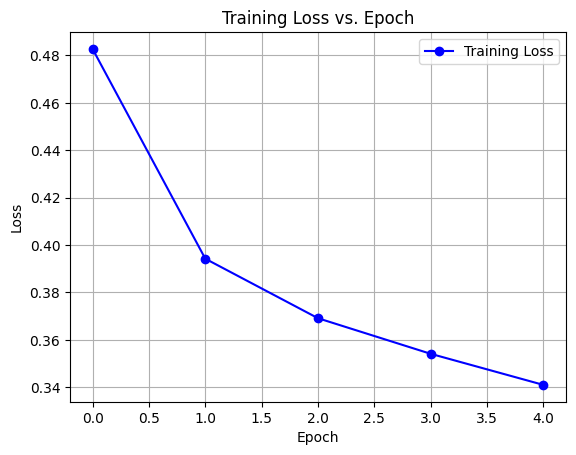

In [2]:
# 设备设置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定义 ResidualBlock
class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout_rate=0.4):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.bn = nn.BatchNorm1d(out_features)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

        self.shortcut = nn.Identity()
        if in_features != out_features:
            self.shortcut = nn.Sequential(
                nn.Linear(in_features, out_features),
                nn.BatchNorm1d(out_features)
            )

        self._init_weights(self.linear)
        if isinstance(self.shortcut, nn.Sequential):
            self._init_weights(self.shortcut[0])

    def _init_weights(self, layer):
        if isinstance(layer, nn.Linear):
            nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.linear(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.dropout(out)
        return out + residual

# 构建模型
net = nn.Sequential(
    nn.Flatten(),
    ResidualBlock(28*28, 256),
    ResidualBlock(256, 128, dropout_rate=0.2),
    nn.Linear(128, 10)
).to(device)

# 超参数设置
lr = 0.001
batch_size = 64
num_epochs = 5
lambda_l2 = 1e-4  # L2 正则化系数


# 损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=lambda_l2)  # L2 正则化由 weight_decay 控制

# 训练过程
train_losses = []

for epoch in range(num_epochs):
    net.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    epoch_loss = total_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# 保存模型
torch.save(net.state_dict(), "model.pth")

# 可视化损失
plt.plot(train_losses, 'b-o', label='Training Loss')
plt.title("Training Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# 下面是计算它的准确率等

In [3]:
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score

net.eval()  # 设置模型为评估模式（禁用 Dropout 等）
all_preds = []
all_labels = []
all_probs = []  # 用于计算 AUC

with torch.no_grad():  # 禁用梯度计算
    for images, labels in test_loader:
        outputs = net(images)

        # 收集预测结果和真实标签
        probs = torch.softmax(outputs, dim=1)  # 获取概率（用于 AUC）
        preds = torch.argmax(outputs, dim=1)   # 获取预测类别

        all_probs.append(probs.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# 拼接所有批次的结果
all_probs = np.concatenate(all_probs)
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# 计算准确率
accuracy = (all_preds == all_labels).mean()
print(f"Accuracy: {accuracy:.4f}")

# 计算 Precision、Recall、F1
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# 计算 AUC（多分类需指定策略）
try:
    auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')
    print(f"AUC (macro-ovr): {auc:.4f}")
except Exception as e:
    print(f"AUC 计算失败: {e}")

Accuracy: 0.8572

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.81      1000
           1       0.94      0.98      0.96      1000
           2       0.68      0.85      0.76      1000
           3       0.92      0.81      0.86      1000
           4       0.82      0.66      0.73      1000
           5       0.94      0.96      0.95      1000
           6       0.68      0.66      0.67      1000
           7       0.93      0.92      0.93      1000
           8       0.95      0.97      0.96      1000
           9       0.95      0.94      0.95      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

AUC (macro-ovr): 0.9886


# 下面是卷积神经网络

In [4]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        # 第一层卷积：输入1通道，输出32通道，kernel=3, stride=1, padding=1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 输出尺寸减半

        # 第二层卷积：32 -> 64通道
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 展平
        self.flatten = nn.Flatten()

        # 全连接层，输入是池化后的展平尺寸：64通道 x 7 x 7 = 3136
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()

        # 输出层：10类，使用 Softmax
        self.fc2 = nn.Linear(128, 10)
        self.softmax = nn.Softmax(dim=1)  # dim=1 表示按行进行 softmax

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)
        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def l2_regularization(model, lambda_):
    l2_norm = sum(torch.sum(param ** 2) for param in model.parameters() if param.requires_grad)
    return lambda_ * l2_norm

# 训练函数
def train_manual(
    model,
    train_loader,
    test_loader,
    epochs=5,
    lr=0.01,
    lambda_l2=0.001,
    device='cpu'
):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    train_losses, test_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss += l2_regularization(model, lambda_l2)

            model.zero_grad()
            loss.backward()

            # 手动SGD更新
            with torch.no_grad():
                for param in model.parameters():
                    if param.grad is not None:
                        param -= lr * param.grad

            total_loss += loss.item()

        train_losses.append(total_loss / len(train_loader))
        acc = evaluate_accuracy(model, test_loader, device)
        test_accuracies.append(acc)
        print(f"Epoch {epoch+1}: Loss={train_losses[-1]:.4f}, Accuracy={acc:.2f}%")

    return train_losses, test_accuracies

def evaluate_accuracy(model, data_loader, device='cpu'):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return 100 * correct / total


def plot_training(losses, accuracies):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(losses, label="Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label="Accuracy", color="orange")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Test Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import numpy as np

def evaluate_model_detailed(model, data_loader, device='cpu'):
    model.eval()
    all_preds, all_probs, all_labels = [], [], []

    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            logits = model(X)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            preds = np.argmax(probs, axis=1)
            all_preds.extend(preds)
            all_probs.extend(probs)
            all_labels.extend(y.numpy())

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    try:
        auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
        print(f"AUC Score (OvR): {auc:.4f}")
    except ValueError:
        print("AUC not computed due to class imbalance or other issues.")



# 训练CNN模型
cnn = CustomCNN()
losses_cnn, accs_cnn = train_manual(cnn, train_loader, test_loader, epochs=5, lr=0.01, lambda_l2=0.001, device=device)
plot_training(losses_cnn, accs_cnn)
evaluate_model_detailed(cnn, test_loader, device)
